# QSudoku Demo: Basic Workflow

This notebook demonstrates the basic workflow of the quantum Sudoku solving framework, focusing on the `QSudoku` master class and `ExactCoverQuantumSolver`.

## Basic Workflow Steps:
1. **Puzzle Creation** - Generate or load a Sudoku puzzle
2. **Solver Setup** - Configure the quantum solving algorithm  
3. **Circuit Building** - Build the quantum circuit
4. **Backend Setup** - Configure simulator or real hardware
5. **Execution** - Run the quantum algorithm

In [1]:
# Import the main QSudoku class and ExactCoverQuantumSolver
from sudoku_nisq import QSudoku
from sudoku_nisq.exact_cover_solver import ExactCoverQuantumSolver

## Step 1: Puzzle Creation

Let's generate a simple 4x4 Sudoku puzzle with some missing cells.

Generated puzzle:
Size: 4x4
Missing cells: 2
Puzzle hash: 0f4037b36a7a94cc9c211b3f972f5bbcb24f7cc9ff6b5aa4500d3ba6c7d39364
Puzzle board: [[3, 2, 1, 4], [0, 0, 3, 2], [2, 1, 4, 3], [4, 3, 2, 1]]


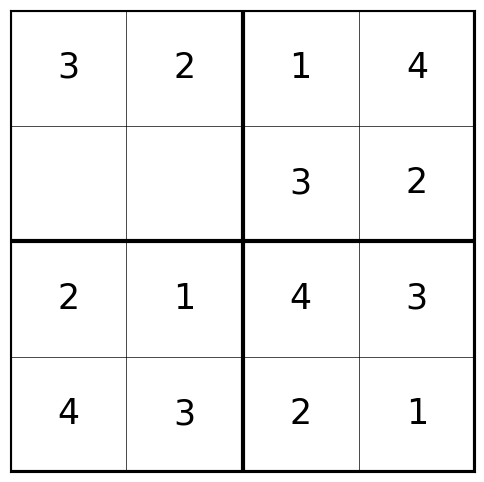

In [2]:
# Generate a 4x4 Sudoku puzzle with 6 missing cells
# subgrid_size=2 means 2x2 subgrids, creating a 4x4 puzzle
puzzle = QSudoku.generate(subgrid_size=2, num_missing_cells=2)

print("Generated puzzle:")
print(f"Size: {puzzle.board_size}x{puzzle.board_size}")
print(f"Missing cells: {puzzle.num_missing_cells}")
print(f"Puzzle hash: {puzzle.get_hash()}")
print(f"Puzzle board: {puzzle.board}")
puzzle.plot()

## Step 2: Solver Setup

Now we'll configure the quantum solving algorithm. We'll use the `ExactCoverQuantumSolver` with the "simple" encoding.

In [3]:
# Set the quantum solving algorithm
puzzle.set_solver(ExactCoverQuantumSolver, encoding="simple")

print("Solver configured:")
print(f"Solver class: {type(puzzle._solver).__name__}")
print(f"Encoding: {puzzle._solver.encoding}")
print(f"Active solver: {puzzle._solver is not None}")

Solver configured:
Solver class: ExactCoverQuantumSolver
Encoding: simple
Active solver: True


## Step 3: Circuit Building

Build the quantum circuit that implements the exact cover algorithm for our puzzle.

In [4]:
# Build the quantum circuit for the puzzle
circuit = puzzle.build_circuit()

print("Circuit built successfully!")

print(f"Circuit qubits: {circuit.n_qubits}")
print(f"Circuit gates: {circuit.n_gates}")
print(f"Circuit depth: {circuit.depth()}")

Circuit built successfully!
Circuit qubits: 11
Circuit gates: 32
Circuit depth: 16


## Step 4: Backend Execution

Now we can run our quantum circuit. We'll use the Aer simulator for this demo, but the same workflow applies to real hardware backends initialized above.

## Backend Initialization

For real quantum hardware experiments, we need to initialize backends first. Let's set up IBM Quantum access.

In [ ]:
# Import the BackendManager for hardware backends
from sudoku_nisq.backends import BackendManager

# Initialize IBM Quantum backend
# Note: Replace with your actual IBM API token and instance
# For demo purposes, we'll show the initialization code but comment it out

# Uncomment and modify these lines with your credentials:
# api_token = "your_ibm_api_token_here"
# instance = "crn:v1:bluemix:public:quantum-computing:us-east:a/your_instance_id"

# BackendManager.init_ibm(
#     api_token=api_token,
#     instance=instance, 
#     device="ibm_brisbane"
# )

BackendManager.add_ibm_device(device="ibm_torino", alias="ibm_torino")

# Check registered backends
print("Available backends in BackendManager:")
available_backends = BackendManager.aliases()
print(f"Registered backends: {available_backends}")

if "ibm_brisbane" in available_backends:
    backend = BackendManager.get("ibm_brisbane")
    print(f"IBM Brisbane backend ready: {type(backend).__name__}")
else:
    print("IBM Brisbane not registered")

if "ibm_torino" in available_backends:
    backend = BackendManager.get("ibm_torino")
    print(f"IBM Torino backend ready: {type(backend).__name__}")
else:
    print("IBM Torino not registered")


### How to Get IBM Credentials

To use real IBM Quantum hardware:

1. **Sign up** at [IBM Quantum Network](https://quantum-computing.ibm.com/)
2. **Get your API token** from your account settings
3. **Find your instance CRN** you currently need to setup a Pay-As-Yo-Go account at least
4. **Choose a device** like `ibm_brisbane`, `ibm_torino`, etc.

The `BackendManager.init_ibm()` method handles both authentication and device registration in one step. Once initialized, you can access the backend anywhere in your code using `BackendManager.get("ibm_brisbane")`.

Running quantum circuit on Aer simulator...
Simulation completed! Creating visualization...


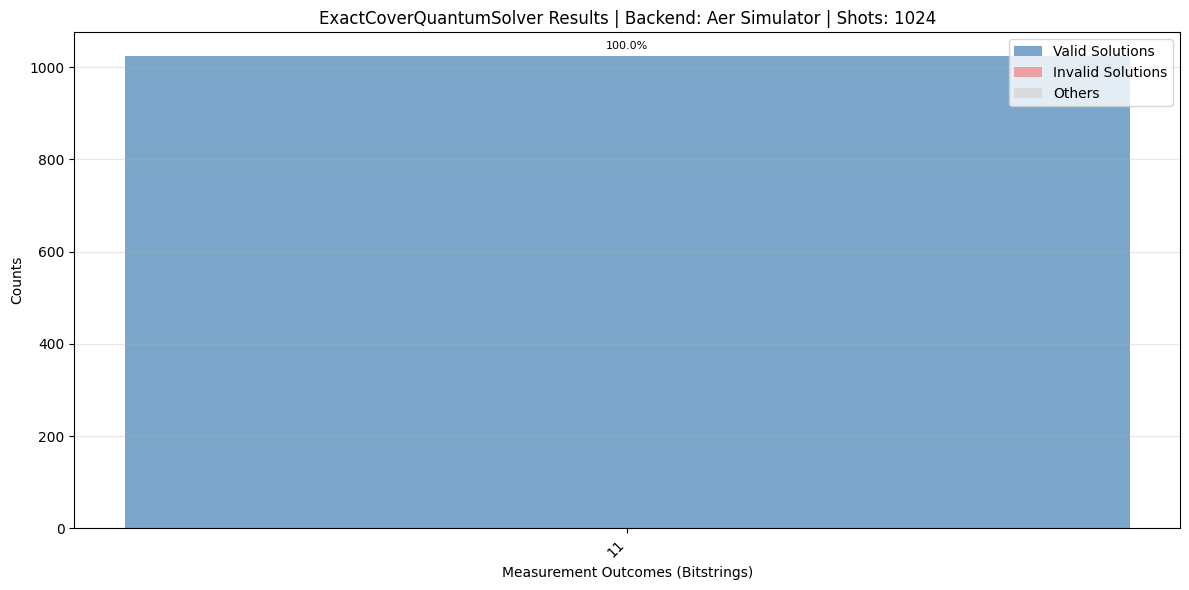


Summary:
Total unique outcomes: 1
Total shots: 1024
Valid solutions found: 1024 (100.00%)
Most frequent outcome: 11 (100.00%)

Additional visualization options:
Top 10 outcomes only:


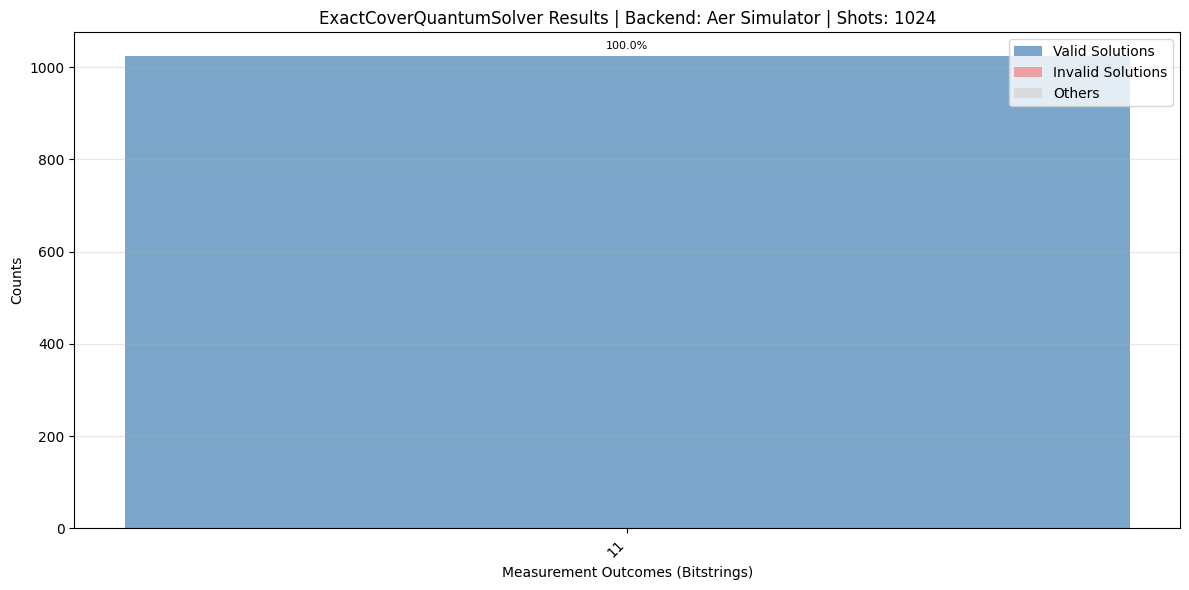


Summary:
Total unique outcomes: 1
Total shots: 1024
Valid solutions found: 1024 (100.00%)
Most frequent outcome: 11 (100.00%)

Raw counts dictionary has 1 unique outcomes
Sample outcomes: {(1, 1): 1024}

Valid solutions only:


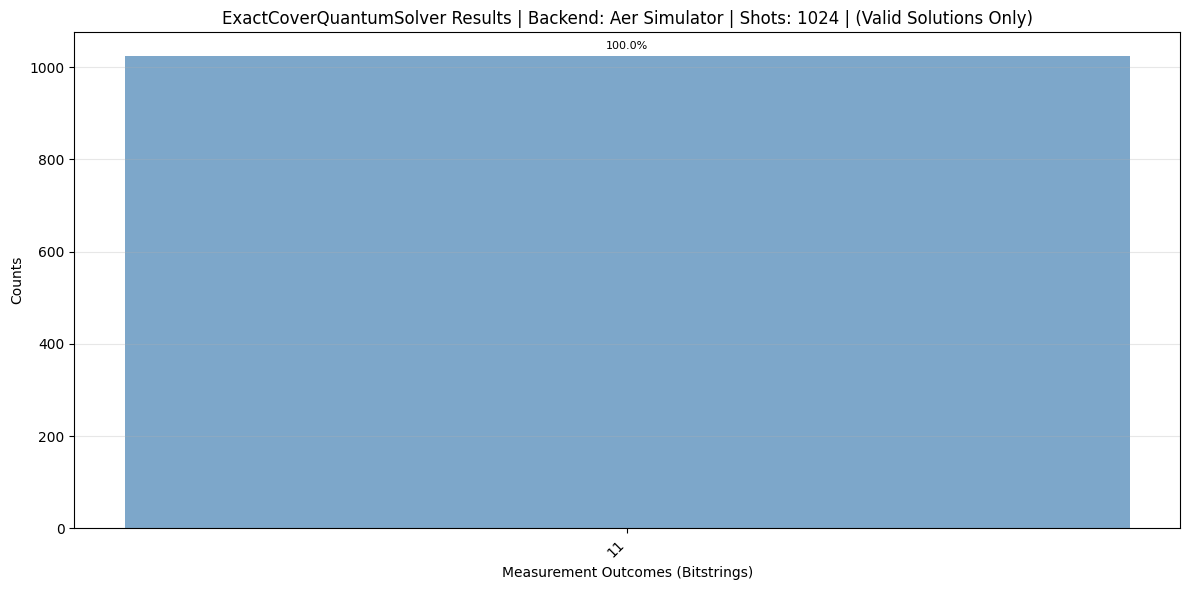


Summary:
Total unique outcomes: 1
Total shots: 1024
Valid solutions found: 1024 (100.00%)
Most frequent outcome: 11 (100.00%)


In [5]:
# Run on the Aer simulator and visualize results
print("Running quantum circuit on Aer simulator...")
result = puzzle.run_aer(shots=1024)

print("Simulation completed! Creating visualization...")

# Use the new counts_plot method to visualize results
puzzle.counts_plot(result, backend_alias="Aer Simulator", shots=1024)

print("\nAdditional visualization options:")

# Show only the top 10 most frequent outcomes
print("Top 10 outcomes only:")
puzzle.counts_plot(result, backend_alias="Aer Simulator", shots=1024, top_n=10)

# Extract counts and use them directly
counts = result.get_counts()
print(f"\nRaw counts dictionary has {len(counts)} unique outcomes")
print("Sample outcomes:", dict(list(counts.items())[:5]))

# Show only valid solutions (if any)
print("\nValid solutions only:")
puzzle.counts_plot(result, backend_alias="Aer Simulator", show_valid_only=True, top_n=5)

Advanced visualization features:


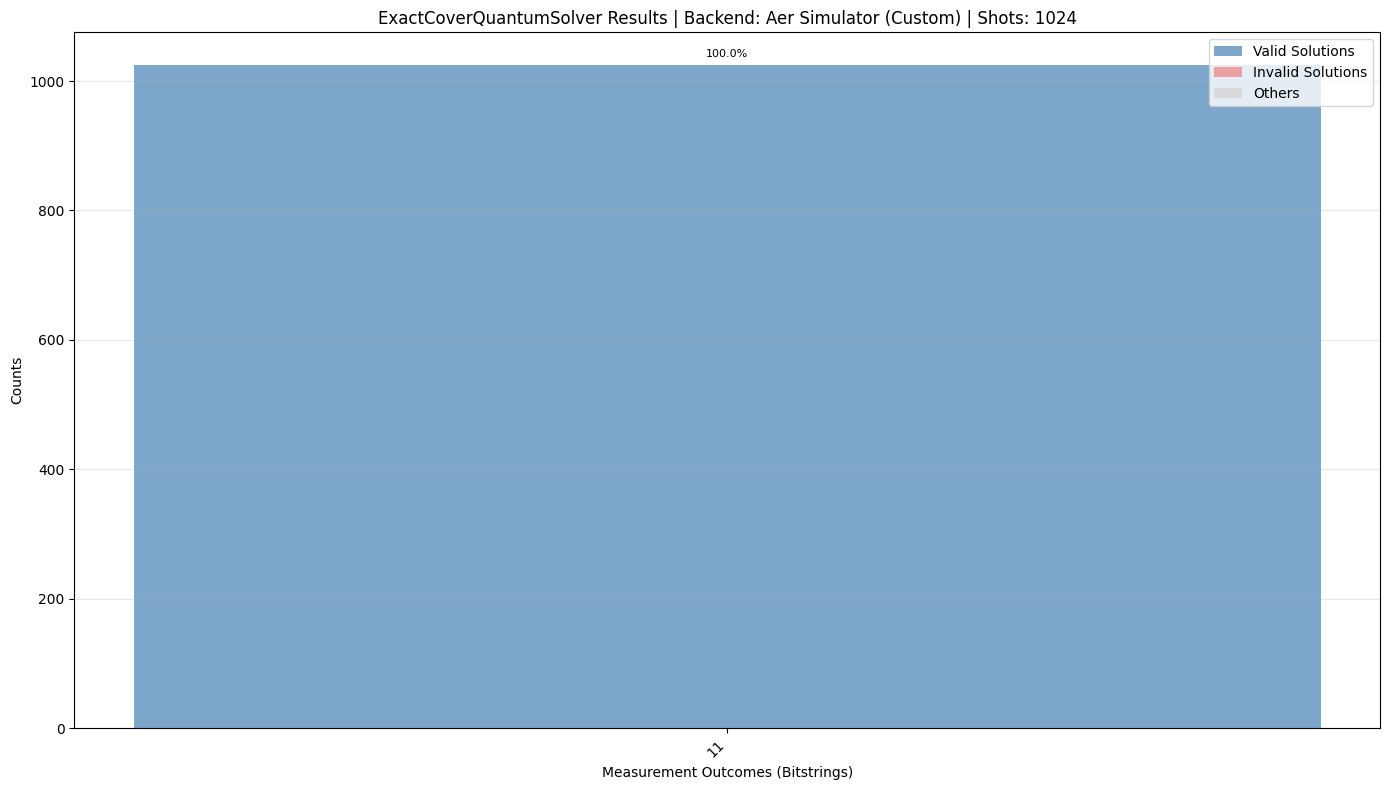


Summary:
Total unique outcomes: 1
Total shots: 1024
Valid solutions found: 1024 (100.00%)
Most frequent outcome: 11 (100.00%)

Running with different shot counts for comparison...


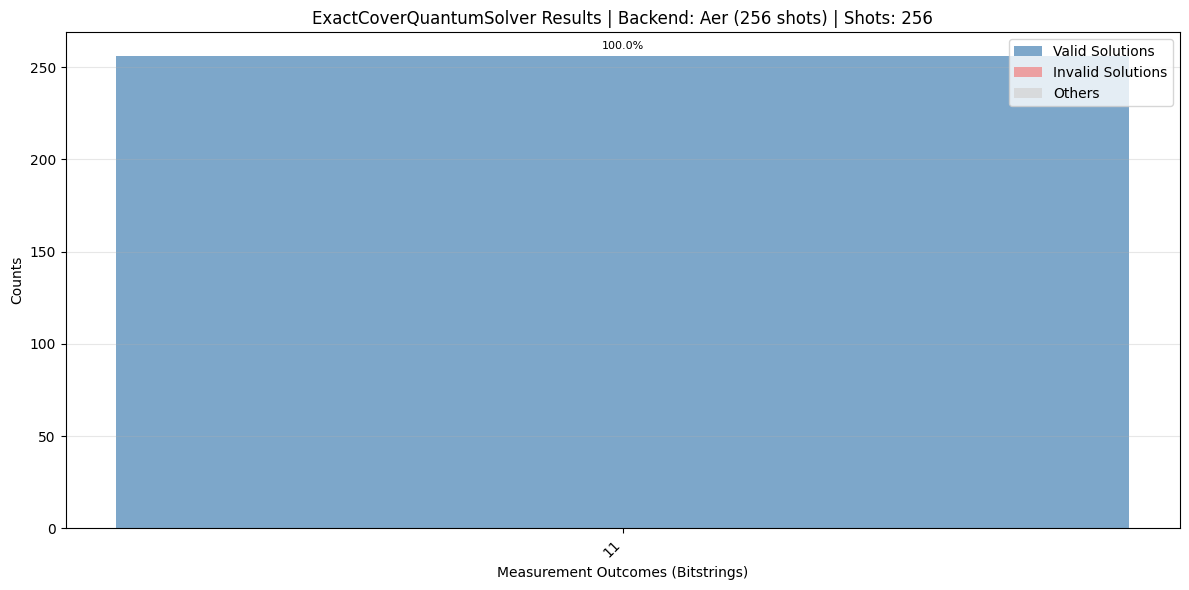


Summary:
Total unique outcomes: 1
Total shots: 256
Valid solutions found: 256 (100.00%)
Most frequent outcome: 11 (100.00%)


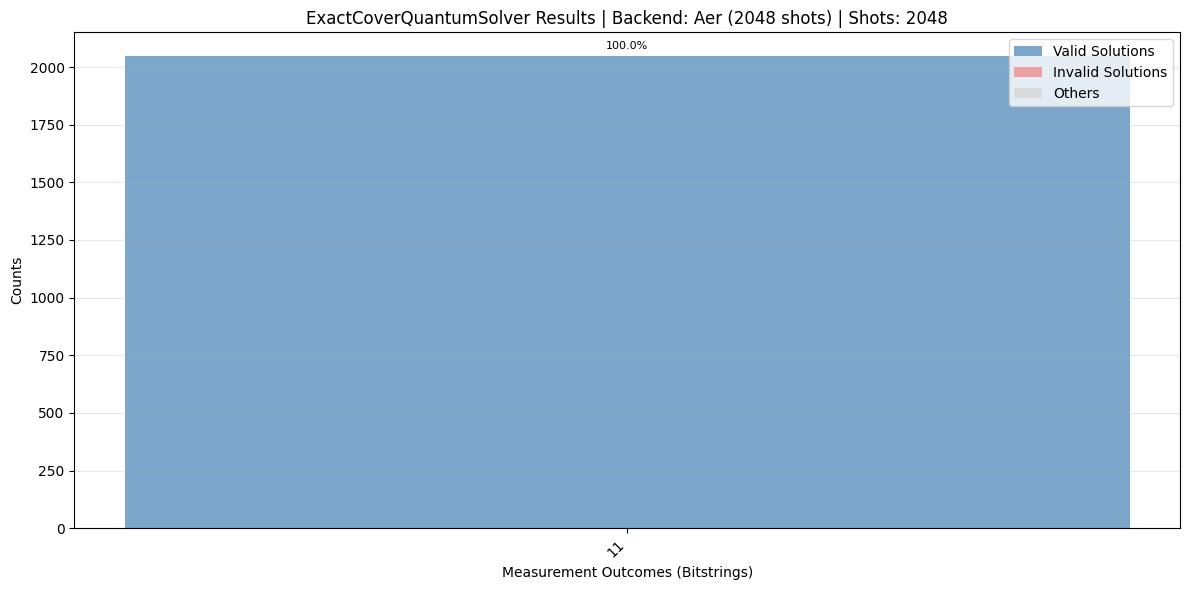


Summary:
Total unique outcomes: 1
Total shots: 2048
Valid solutions found: 2048 (100.00%)
Most frequent outcome: 11 (100.00%)

Notice how the distribution changes with different shot counts!


In [6]:
# Demonstrate advanced counts plot features
print("Advanced visualization features:")

# Custom figure size for better visibility
puzzle.counts_plot(
    result, 
    backend_alias="Aer Simulator (Custom)", 
    shots=1024,
    top_n=15,
    figsize=(14, 8)
)

# Compare with different shot counts for the same puzzle
print("\nRunning with different shot counts for comparison...")

# Run with fewer shots
result_256 = puzzle.run_aer(shots=256)
puzzle.counts_plot(result_256, backend_alias="Aer (256 shots)", shots=256, top_n=10)

# Run with more shots  
result_2048 = puzzle.run_aer(shots=2048)
puzzle.counts_plot(result_2048, backend_alias="Aer (2048 shots)", shots=2048, top_n=10)

print("\nNotice how the distribution changes with different shot counts!")

## Counts Plot Features

The new `counts_plot()` method provides rich visualization for quantum Sudoku results:

### 🎯 **Key Features Demonstrated:**

1. **Automatic Result Processing**: Works directly with pytket Result objects
2. **Color-Coded Validation**: Green bars for valid solutions, red for invalid, gray for aggregated outcomes
3. **Statistical Information**: Shows both counts and percentages on each bar
4. **Top-N Filtering**: Displays only the most frequent outcomes to avoid clutter
5. **Summary Statistics**: Prints detailed statistics including validity percentages
6. **Flexible Input**: Accepts Result objects, count dictionaries, or uses default parameters

### 📊 **Customization Options:**

- `backend_alias`: Custom labels for different backends/experiments
- `shots`: Override shot count for percentage calculations
- `top_n`: Limit number of bars shown (default: 20)
- `show_valid_only`: Filter to show only valid Sudoku solutions
- `figsize`: Customize plot dimensions

### 🔬 **Research Applications:**

This visualization is perfect for:
- Comparing algorithm performance across different encodings
- Analyzing the effect of shot noise on solution quality
- Identifying the most promising quantum states
- Validating quantum advantage claims with clear statistical evidence

The counts plot bridges the gap between raw quantum measurement data and meaningful insights about Sudoku solving performance!

## Summary

We've successfully demonstrated the basic QSudoku workflow:

1. ✅ **Generated** a 4x4 Sudoku puzzle
2. ✅ **Configured** the ExactCoverQuantumSolver
3. ✅ **Built** the quantum circuit
4. ✅ **Executed** on the Aer simulator

The framework automatically handles:
- Circuit caching and optimization
- Error handling and validation  
- Metadata collection and logging
- Memory management

Next, we can explore the `ExperimentRunner` for bulk experimentation!

# ExperimentRunner Demo: Bulk Experimentation

The `ExperimentRunner` enables systematic benchmarking across multiple parameters. Let's run a small batch experiment.

In [ ]:
# Import the convenience function for batch experiments
from sudoku_nisq import run_experiment_batch

# Run a small batch experiment
# This will test ExactCoverQuantumSolver with 2 encodings 
# on 2 different puzzle difficulties, with 2 samples each
print("Starting small batch experiment...")

# For this demo, we'll use the simulator
# In practice, you'd use the backends you initialized above
backends_to_test = ["ibm_brisbane", "ibm_torino"]
print(f"Testing with backends: {backends_to_test}")

csv_path = run_experiment_batch(
    solvers_config={
        ExactCoverQuantumSolver: ["simple", "pattern"]  # 2 encodings
    },
    backends=backends_to_test,
    puzzle_sizes=[2],        # 4x4 puzzles only  
    missing_cells=[3, 5],    # 2 difficulty levels
    samples_per_combo=2,     # 2 puzzle samples per combination
    csv_path="demo_experiment.csv",
    cache_base="./demo_cache"
)

print(f"\nExperiment completed! Results saved to: {csv_path}")

Starting small batch experiment...


ValueError: Backend 'simulator' not found in BackendManager. Available backends: []

In [ ]:
# Let's examine the results
import pandas as pd
import os

if os.path.exists("demo_experiment.csv"):
    df = pd.read_csv("demo_experiment.csv")
    
    print(f"Experiment generated {len(df)} CSV rows")
    print(f"Columns: {list(df.columns)}")
    
    print("\nBreakdown by solver and encoding:")
    breakdown = df.groupby(['solver_name', 'encoding']).size()
    print(breakdown)
    
    print("\nSample of circuit resources:")
    resource_cols = ['main_n_qubits', 'main_n_gates', 'main_depth']
    available_cols = [col for col in resource_cols if col in df.columns]
    if available_cols:
        print(df[['solver_name', 'encoding'] + available_cols].head())
    
    print("\nAny errors encountered:")
    if 'error' in df.columns:
        errors = df[df['error'].notna()]
        if len(errors) > 0:
            print(f"Found {len(errors)} errors")
            print(errors[['solver_name', 'encoding', 'error']].head())
        else:
            print("No errors found - all experiments succeeded!")
    
else:
    print("CSV file not found - experiment may not have completed")

## What Just Happened?

The `ExperimentRunner` systematically tested:

- **2 solver encodings** (simple, pattern)
- **2 puzzle difficulties** (3 and 5 missing cells)  
- **2 samples per combination** (for statistical reliability)
- **1 backend** (simulator)

This generated **8 total CSV rows**:
- 4 puzzles × 2 encodings × 1 main circuit row each = 8 rows

Each row contains:
- Puzzle metadata (size, missing cells, hash)
- Solver configuration (name, encoding) 
- Circuit resources (qubits, gates, depth)
- Any errors encountered

## Key Benefits

1. **Systematic**: Tests all parameter combinations
2. **Robust**: Continues even if individual experiments fail
3. **Comprehensive**: Logs everything to CSV for analysis
4. **Memory-safe**: Automatic cleanup prevents memory leaks
5. **Progress tracking**: Real-time updates during long runs

## Next Steps

For real research, you might run:
```python
run_experiment_batch(
    solvers_config={
        ExactCoverQuantumSolver: ["simple", "pattern", "optimized"],
        GraphColoringQuantumSolver: ["basic", "advanced"]
    },
    backends=["ibm_brisbane", "ibm_kyoto", "simulator"],
    puzzle_sizes=[2, 3],  # 4x4 and 9x9
    missing_cells=[3, 5, 7, 10],
    samples_per_combo=20,  # More statistical samples
    opt_levels=[0, 1, 2, 3]  # Test transpilation optimization
)
```

This would generate hundreds of data points for comprehensive analysis!